In [1]:
import numpy as np
import pandas as pd
import os
import torch
import pymupdf

# Retrieval Augmented Generation

**RAG pipeline**


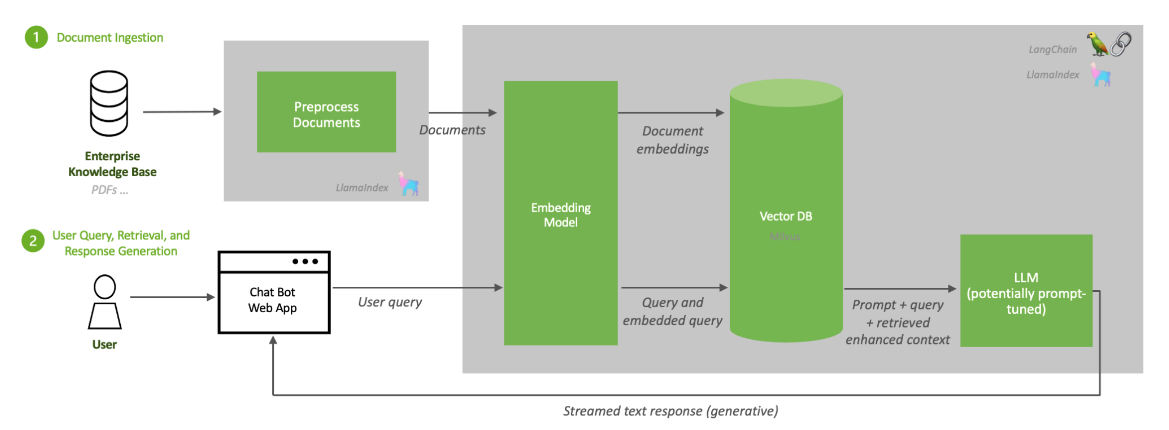

Base on the RAG pipeline, we will divided our works into section
1. Preprocess document: The document we will be used is PDF format. From PDF file, we will read the data, and convert it into multiple chunks

## Preprocess document

In [2]:
file_path = "doc/Computer Networks.pdf"

# Testing PyMuPDF
doc = pymupdf.open(file_path)
sample_texts = [doc[i].get_text() for i in range(20, 30)]
sample_texts

['PREFACE\nThis book is now in its ﬁfth edition. Each edition has corresponded to a dif-\nferent phase in the way computer networks were used. When the ﬁrst edition ap-\npeared in 1980, networks were an academic curiosity. When the second edition\nappeared in 1988, networks were used by universities and large businesses. When\nthe third edition appeared in 1996, computer networks, especially the Internet, had\nbecome a daily reality for millions of people. By the fourth edition, in 2003, wire-\nless networks and mobile computers had become commonplace for accessing the\nWeb and the Internet. Now, in the ﬁfth edition, networks are about content dis-\ntribution (especially videos using CDNs and peer-to-peer networks) and mobile\nphones are small computers on the Internet.\nNew in the Fifth Edition\nAmong the many changes in this book, the most important one is the addition\nof Prof. David J. Wetherall as a co-author. David brings a rich background in net-\nworking, having cut his teeth d

In [3]:
text = sample_texts[2]

# Clean any escape character: \n \t ..
filter = ''.join([chr(i) for i in range(1, 32)])
text = text.replace('\n', ' ')
text = text.translate(str.maketrans('', '', filter)).strip()
text = text.replace(u'\xa0', u' ')
print(text)
print(len(text))

PREFACE xxi List of Acronyms Computer books are full of acronyms. This one is no exception. By the time you are ﬁnished reading this one, the following should ring a bell: ADSL, AES, AJAX, AODV, AP, ARP, ARQ, AS, BGP, BOC, CDMA, CDN, CGI, CIDR, CRL, CSMA, CSS, DCT, DES, DHCP, DHT, DIFS, DMCA, DMT, DMZ, DNS, DOCSIS, DOM, DSLAM, DTN, FCFS, FDD, FDDI, FDM, FEC, FIFO, FSK, FTP, GPRS, GSM, HDTV, HFC, HMAC, HTTP, IAB, ICANN, ICMP, IDEA, IETF, IMAP, IMP, IP, IPTV, IRTF, ISO, ISP, ITU, JPEG, JSP, JVM, LAN, LATA, LEC, LEO, LLC, LSR, LTE, MAN, MFJ, MIME, MPEG, MPLS, MSC, MTSO, MTU, NAP, NAT, NRZ, NSAP, OFDM, OSI, OSPF, PAWS, PCM, PGP, PIM, PKI, POP, POTS, PPP, PSTN, QAM, QPSK, RED, RFC, RFID, RPC, RSA, RTSP, SHA, SIP, SMTP, SNR, SOAP, SONET, SPE, SSL, TCP, TDD, TDM, TSAP, UDP, UMTS, URL, VLAN, VSAT, WAN, WDM, and XML. But don’t worry. Each will appear in boldface type and be carefully deﬁned before it is used. As a fun test, see how many you can identify before reading the book, write the number

**Chunk method**

For the chunk method, we will use **Fixed size chunking** method:
This is the most common and straightforward approach for chunking. 
Beside, overlapping will be used maintain the semantic context between each chunks

In [4]:
def fixed_size_chunking(text: str, chunk_size=32):
    words = text.split(' ')
    output = []

    for i in range(len(words) - chunk_size + 1):
        chunk = ' '.join(words[i:i + chunk_size])
        output.append(chunk)

    return output


fixed_size_chunking(text)[:5]

['PREFACE xxi List of Acronyms Computer books are full of acronyms. This one is no exception. By the time you are ﬁnished reading this one, the following should ring a bell: ADSL,',
 'xxi List of Acronyms Computer books are full of acronyms. This one is no exception. By the time you are ﬁnished reading this one, the following should ring a bell: ADSL, AES,',
 'List of Acronyms Computer books are full of acronyms. This one is no exception. By the time you are ﬁnished reading this one, the following should ring a bell: ADSL, AES, AJAX,',
 'of Acronyms Computer books are full of acronyms. This one is no exception. By the time you are ﬁnished reading this one, the following should ring a bell: ADSL, AES, AJAX, AODV,',
 'Acronyms Computer books are full of acronyms. This one is no exception. By the time you are ﬁnished reading this one, the following should ring a bell: ADSL, AES, AJAX, AODV, AP,']

In [5]:
def clean_text(text: str):
    # filter = ''.join([chr(i) for i in range(1, 32)])
    # text = text.translate(str.maketrans('', '', filter)).strip()
    text = text.replace('-\n', '')
    text = text.replace('\n', ' ')
    text = text.replace(u'\xa0', u' ')

    while text.find('  ') != -1:
        text = text.replace('  ', ' ') 

    return text

def load_document(file_path: str, chunk_size=32):
    """
    Loads pdf from `file_path` and generate list of chunks from the file
    """
    doc = pymupdf.open(file_path)
    output = []

    chunk_id = 0
    for i, page in enumerate(doc):
        # Get text per page
        text = page.get_text()

        # Clean text
        text = clean_text(text)

        words = text.split(' ')
        for j in range(0, len(words) - chunk_size + 1, 2):
            chunk = ' '.join(words[j:j + chunk_size])

            output.append({
                'chunk_id': chunk_id,
                'page': i,
                'text': chunk,
            })

            chunk_id += 1
    
    return output

chunks = load_document(file_path)
chunks[:5]

[{'chunk_id': 0,
  'page': 4,
  'text': 'COMPUTER NETWORKS FIFTH EDITION ANDREW S. TANENBAUM Vrije Universiteit Amsterdam, The Netherlands DAVID J. WETHERALL University of Washington Seattle, WA PRENTICE HALL Boston Columbus Indianapolis New York San Francisco Upper Saddle River'},
 {'chunk_id': 1,
  'page': 4,
  'text': 'FIFTH EDITION ANDREW S. TANENBAUM Vrije Universiteit Amsterdam, The Netherlands DAVID J. WETHERALL University of Washington Seattle, WA PRENTICE HALL Boston Columbus Indianapolis New York San Francisco Upper Saddle River Amsterdam Cape'},
 {'chunk_id': 2,
  'page': 4,
  'text': 'ANDREW S. TANENBAUM Vrije Universiteit Amsterdam, The Netherlands DAVID J. WETHERALL University of Washington Seattle, WA PRENTICE HALL Boston Columbus Indianapolis New York San Francisco Upper Saddle River Amsterdam Cape Town Dubai'},
 {'chunk_id': 3,
  'page': 4,
  'text': 'TANENBAUM Vrije Universiteit Amsterdam, The Netherlands DAVID J. WETHERALL University of Washington Seattle, WA PRENTIC

In [6]:
df = pd.DataFrame(chunks)
df['num_words'] = df.apply(lambda x : len(x['text'].split(' ')), axis=1)
df['num_char'] = df.apply(lambda x : len(x['text']), axis=1)
df

,chunk_id,page,text,num_words,num_char
0,0,4,COMPUTER NETWORKS FIFTH EDITION ANDREW S. TANE...,32,238
1,1,4,FIFTH EDITION ANDREW S. TANENBAUM Vrije Univer...,32,235
2,2,4,ANDREW S. TANENBAUM Vrije Universiteit Amsterd...,32,232
3,3,4,"TANENBAUM Vrije Universiteit Amsterdam, The Ne...",32,236
4,4,4,"Universiteit Amsterdam, The Netherlands DAVID ...",32,232
...,...,...,...,...,...
192777,192777,961,"and MobiSys, and cofounded the ACM HotNets wor...",32,203
192778,192778,961,and cofounded the ACM HotNets workshops. He ha...,32,201
192779,192779,961,the ACM HotNets workshops. He has served on nu...,32,195
192780,192780,961,HotNets workshops. He has served on numerous p...,32,196


In [7]:
df.describe()

,chunk_id,page,num_words,num_char
count,192782.000000,192782.000000,192782.0,192782.000000
mean,96390.500000,483.769175,32.0,187.460048
std,55651.514135,266.907348,0.0,22.528302
min,0.000000,4.000000,32.0,63.000000
25%,48195.250000,254.000000,32.0,174.000000
50%,96390.500000,484.000000,32.0,186.000000
75%,144585.750000,717.000000,32.0,200.000000
max,192781.000000,961.000000,32.0,397.000000


Current document: **Andrew S. Tanenbaum - Computer Networks**

Base on the data description, each chunk has 32 number of words and no exception. However, the number of tokens in each chunk can be varied after tokenizing due to the different chunk's length.

For number of character per chunk, most of chunk (75%) under 200 characters, while the highest one has 397 characters.

## Embedding

In [122]:
from transformers import AutoTokenizer, AutoModel

model_name = "BAAI/bge-small-en-v1.5"

model_path = "../model/bge-small-en-v1.5/model"
tokenizer_path = "../model/bge-small-en-v1.5/tokenizer"
device = "cuda:0" if torch.cuda.is_available() else "cpu"

RESET = True
tokenizer = None
model = None

if os.path.isdir(tokenizer_path) and os.path.isdir(model_path) and not RESET:
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
    model = AutoModel.from_pretrained(model_path)
    
else:
    # Then init
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.to(device)

    tokenizer.save_pretrained(tokenizer_path)
    model.save_pretrained(model_path)


assert tokenizer is not None
assert model is not None

In [95]:
def get_embedding(text: list[str] | str):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True).to(device)

    with torch.no_grad():
        # reduce mean in sequence length axis
        output = model(**inputs).last_hidden_state.mean(dim=1)

    return output.tolist()

ce_output = get_embedding("When the second edition appeared in 1988, networks were used by universities and large businesses")
len(ce_output[0])

384

As we are using **BAAI/bge-small-en-v1.5** model, the final output will have shape (384, ), which mean a single chunk will be performed by 384 dimensional vector.

In [25]:
%reset

Nothing done.


## Vector DB

In [103]:
sample_size = 100000
df = pd.read_csv('../csv/Computer Networks.csv', nrows=sample_size)

As the embedding column is in string format, we have to convert into numpy array

In [116]:
# Load sample vectors
sample = df[['chunk_id', 'embedding']].values

sample_vector_store = {}

for i in range(len(sample)):
    sample_vector_store[sample[i, 0]] = np.array(sample[i, 1].strip('[]').split(', '), dtype=np.float32)

## Retrieval

Cosine similarity formula:
$$cosine\_similarity = \frac{A.B}{||A||.||B||}$$

In [2]:
# Calculate cosine similarity
def cosine_similarity(a, b):
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)

    if norm_a == 0 or norm_b == 0:
        return 0
    else:
        return np.dot(a, b) / (norm_a * norm_b)
    
a = np.array([3, 4, 5])
b = np.array([5, 6, 7])
cosine_similarity(a, b)

0.9978157964455983

In [48]:
# TEST VERSION
def get_matches(vector_store, query, top_k=50):
    scores = {}

    for vector_key in vector_store:
        vector_item = vector_store[vector_key]
        scores[vector_key] = cosine_similarity(query, vector_item)

    def func(e):
        return e[1]
    
    # Sorted by cosine scores
    scores = sorted(scores.items(), key=func, reverse=True)[:top_k]

    return scores


# Test 
test_vs_0 = {}

for i in range(10):
    test_vs_0[i] = np.random.random((3, ))

print(f"Vector store: \n{test_vs_0}\n")

print(f"Cosine Similarity: \n{get_matches(test_vs_0, np.array([0.2, 0.7, 0.07]), 5)}")

Vector store: 
{0: array([0.177073  , 0.50143417, 0.47630255]), 1: array([0.42220721, 0.02768533, 0.4970772 ]), 2: array([0.81733236, 0.38787242, 0.27379366]), 3: array([0.371526  , 0.30983071, 0.01449112]), 4: array([0.17239729, 0.54121062, 0.30208835]), 5: array([0.56877938, 0.19258701, 0.23682549]), 6: array([0.00262059, 0.98569271, 0.14680088]), 7: array([0.70213175, 0.85413904, 0.86850407]), 8: array([0.71023281, 0.35003389, 0.75706804]), 9: array([0.67637031, 0.21338164, 0.61176346])}

Cosine Similarity: 
[(6, 0.9614831398179673), (4, 0.9233909412442515), (3, 0.8255019506486216), (0, 0.8039447701018926), (7, 0.7771219530891641)]


The `get_matches` function finds the top_k most similar chunks compared to query. Take query (str) as the input:
- We embed the query into (384, ) dimensional vector.
- Perform **cosine_similarity** formula to each chunk vector in vector_stores.
- Take most top_k highest scores from output. 

In [111]:
def get_matches(vector_store, query: str, top_k: int=100):
    # Embedding query
    ce_output = get_embedding(query)[0] # (1, 384)

    scores = {}

    for vector_key in vector_store:
        vector_item = vector_store[vector_key]
        scores[vector_key] = cosine_similarity(ce_output, vector_item)

    def func(e):
        return e[1]
    
    # Sorted by cosine scores
    scores = sorted(scores.items(), key=func, reverse=True)[:top_k]
    ids = [score[0] for score in scores]

    return scores, ids

# Test 
test_vs_0 = {}

for i in range(10):
    test_vs_0[i] = np.random.random((384, ))

output, id = get_matches(test_vs_0, 'heloo', 5)
print(f"Cosine Similarity: \n{output}")

Cosine Similarity: 
[(4, 0.06379185378357753), (6, 0.024395132615303662), (2, 0.019512683535494374), (8, 0.016527839576342563), (9, 0.006844442623905415)]


## Augmenting & Generative
In this section, we will augment extracted similar chunk to our prompt. For this project, we will use **Gemini API**

In [60]:
from dotenv import load_dotenv
import google.generativeai as genai

load_dotenv()

API_KEY = os.getenv('API_KEY')
genai.configure(api_key=API_KEY)

In [123]:
gen_model = genai.GenerativeModel('gemini-1.0-pro-latest')
# Test
gen_model.generate_content("What is the main part of the integrated services architecture").text

'Service delivery environment'

In [83]:
def create_prompt(query: str, info: list[str]):
    ret = '\n- '
    prompt = f"I have the following information: \n- {ret.join(info)} \
    \nNow, i want you taking those information and answer the following question \
    \n\n{query} \n \
    \nMake sure the answers are as explainotary as possible."
    return prompt

print(create_prompt('question', ['info1', 'info2']))

I have the following information: 
- info1
- info2     
Now, i want you taking those information and answer the following question     

question 
     
Make sure the answers are as exlplainotary as possible.


In [124]:
query = "What is the main part of the integrated services architecture"

_, match_ids = get_matches(sample_vector_store, query)

# get list text from matches id
info = df[df['chunk_id'].isin(match_ids)]['text'].tolist()

prompt = create_prompt(query, info)
print(prompt)

gen_model = genai.GenerativeModel('gemini-1.0-pro-latest')
gen_model.generate_content(prompt).text

I have the following information: 
- purpose of each layer is to offer certain services to the higher layers while shielding those layers from the details of how the offered services are actually implemented. In a sense, each
- the offered services are actually implemented. In a sense, each layer is a kind of virtual machine, offering certain services to the layer above it. This concept is actually a familiar one
- services are actually implemented. In a sense, each layer is a kind of virtual machine, offering certain services to the layer above it. This concept is actually a familiar one and is
- the specification of the interfaces is part of the architecture because these are hidden away inside the machines and not visible from the outside. It is not even necessary that the interfaces
- of the interfaces is part of the architecture because these are hidden away inside the machines and not visible from the outside. It is not even necessary that the interfaces on all
- interfaces is pa

'The main part of the integrated services architecture that is visible to the users of the network is RSVP (Resource reSerVation Protocol). RSVP is used for making reservations for resources along the path of a data flow, ensuring that the flow will have the necessary bandwidth and other resources to meet its quality of service requirements.'